# Network Analysis

The goal of this file is to conduct network analysis so that I can build "Stranger Detector." I will use a network metric called **shortest path length**, which denotes the number of steps in the shortest possible path between each pair of nodes. 

In this file, I will:  

* 1) create an edge list by using to and from information

* 2) import the edge list into a graph,

* 3) run network EDA, and

* 4) calculate pairwise path-length information. 


* Input: Parsed email dataset (parsed_email.csv)
* Output: 1) List of distant pairs (3+) and 2) Pairwise path length 

## 1. Loading libraries and data

In [106]:
import os, sys, collections
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [107]:
path_to_email_data = 'C:/Users/Margeum/Dropbox/DS projects/05. Email data/emails_in_csv'
os.chdir(path_to_email_data)

emails_df = pd.read_csv('./emails_parsed.csv')
emails_df.head()

,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",frozenset(['phillip.allen@enron.com']),frozenset(['tim.belden@enron.com']),NaN,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",frozenset(['phillip.allen@enron.com']),frozenset(['john.lavorato@enron.com']),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",frozenset(['phillip.allen@enron.com']),frozenset(['leah.arsdall@enron.com']),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",frozenset(['phillip.allen@enron.com']),frozenset(['randall.gay@enron.com']),NaN,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",frozenset(['phillip.allen@enron.com']),frozenset(['greg.piper@enron.com']),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


## 2. Create an edge list

Use "From" and "To" columns to create edges

In [108]:
edges = pd.DataFrame(emails_df[['From', 'To', 'Date']].copy()).dropna()
edges.reset_index(drop=True, inplace=True)
#print (edges['To'][0:20])

Grab information from the email dataframe and put it in a respective column in the edge list

In [109]:
from_list = []
to_list = []

for i in range(0, len(edges)):
    from_string = ''
    for j in range(len(list(edges['From'][i]))):
        from_string += list(edges['From'][i])[j]
    from_string = from_string.split('frozenset')[1].split('\'')[1]
    to_string = ''
    for j in range(len(list(edges['To'][i]))):
        to_string += list(edges['To'][i])[j]
    to_string = to_string.split('frozenset')[1].split('\'')[1]
    if from_string.find('@enron.com') > 0:    # Use emails between Enron accounts only
        if to_string.find('@enron.com') > 0:    # Use emails between Enron accounts only
            from_list.append(from_string)
            to_list.append(to_string)
            
edgelist_df = pd.DataFrame({'From':from_list,'To':to_list}) # 'Year': year_list,           'Month':month_list, "Date":date_list, "Day":day_list,            "TimeZone":timezone_list
edgelist_df.insert(0, 'EdgeID', range(0, 0 + len(edgelist_df)))
print edgelist_df.head() # This is an edgelist of the entire email dataset

KeyboardInterrupt: 

In [62]:
# Extract from email addresses (both From and To), user's name (folowing the user name convention of "last-firstletteroffirstname")
# Creating filter whether from and to accounts matches any of the 150 folder names. We will conduct network analysis for these 150 people

user = set(emails_df['user'])

edgelist_df['from_filter'] = 'NaN'
edgelist_df['to_filter'] = 'NaN'

edgelist_df['from_foldername'] = 'NaN'
edgelist_df['to_foldername'] = 'NaN'

i = 0
for index, row in edgelist_df.iterrows():

    # From each email address, create user name following the raw data's convention: last name-first letter of the first name
    current_email_from = row['From']
    try:    # In some cases,"To" column is empty
        if len(current_email_from.split('.')) > 0:
            firstletter_from = list(current_email_from.split('.')[0])[0]  #first letter of the first name
        else:
            firstletter_from = ''
    except:
        print('Row:', i, row['From'], row['To'])  
        continue
    lastname_from = current_email_from.split('@')[0].split('.')[-1]
    user_to_match_from = lastname_from + '-' + firstletter_from    # This is the current "from" address's user name
    matches_from = [c for c in user if c in user_to_match_from]    # See if the currnet "from" address's user name matches any of those in the 150 email accounts
    true_val_from = len(matches_from)
    edgelist_df.set_value(index,'from_filter',true_val_from)
    edgelist_df.set_value(index,'from_foldername',user_to_match_from)    
        
    current_email_to = row['To']
    try:    # In some cases,"To" column is empty
        if len(list(current_email_to.split('.')[0])[0]) > 0:
            firstletter_to = list(current_email_to.split('.')[0])[0]  #first letter of the first name
        else:
            firstletter_to = ''
    except:
        print('Row:', i, row['From'], row['To'])  
        continue
    lastname_to = current_email_to.split('@')[0].split('.')[-1]
    user_to_match_to = lastname_to + '-' + firstletter_to
    matches_to = [c for c in user if c in user_to_match_to]
    true_val_to = len(matches_to)
    edgelist_df.set_value(index,'to_filter',true_val_to)
    edgelist_df.set_value(index,'to_foldername',user_to_match_to)
    
    i += 1

print edgelist_df.head()    


C:\Users\Margeum\Anaconda2\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Margeum\Anaconda2\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Margeum\Anaconda2\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Margeum\Anaconda2\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


('Row:', 174744, 'louise.kitchen@enron.com', '.lloyd@enron.com')
('Row:', 264869, '.franklin@enron.com"])', 'kristin.quinn@enron.com')
('Row:', 267877, '.franklin@enron.com"])', 'scott.dicke@enron.com')
   EdgeID                     From                       To from_filter  \
0       0  phillip.allen@enron.com     tim.belden@enron.com           1   
1       1  phillip.allen@enron.com  john.lavorato@enron.com           1   
2       2  phillip.allen@enron.com   leah.arsdall@enron.com           1   
3       3  phillip.allen@enron.com    randall.gay@enron.com           1   
4       4  phillip.allen@enron.com     greg.piper@enron.com           1   

  to_filter from_foldername to_foldername  
0         0         allen-p      belden-t  
1         1         allen-p    lavorato-j  
2         0         allen-p     arsdall-l  
3         1         allen-p         gay-r  
4         0         allen-p       piper-g  


In [63]:
# Save just in case
edgelist_df.to_csv('edgelist_df.csv', index=True)

In [111]:
#edgelist_df = pd.read_csv('./edgelist_df.csv')
edgelist_df.head()
#edgelist_df.to_csv('edgelist_df.csv', index=True)

,Unnamed: 0,EdgeID,From,To,from_filter,to_filter,from_foldername,to_foldername
0,0,0,phillip.allen@enron.com,tim.belden@enron.com,1.0,0.0,allen-p,belden-t
1,1,1,phillip.allen@enron.com,john.lavorato@enron.com,1.0,1.0,allen-p,lavorato-j
2,2,2,phillip.allen@enron.com,leah.arsdall@enron.com,1.0,0.0,allen-p,arsdall-l
3,3,3,phillip.allen@enron.com,randall.gay@enron.com,1.0,1.0,allen-p,gay-r
4,4,4,phillip.allen@enron.com,greg.piper@enron.com,1.0,0.0,allen-p,piper-g


In [112]:
# Now, let's select into the to-from edges which originate AND arrived at the 150 ENRON.COM users' email account
enron_edgelist_df = edgelist_df[edgelist_df["from_filter"] == 1]
enron_edgelist_df = enron_edgelist_df[enron_edgelist_df["to_filter"] == 1]

## 3. Entity recognition

There are instances where mutiple email accounts creating the same user name. For example, both mathew.smith@enron.com and mike.smith@enron.com match "m-smith" username. We will take care of these cases by taking the most frequently appearing email account for each user name.

In [113]:
# For "From" email addresses and the associated user names, 
# list the email addresses per user-name and keep only those with the highest volumne of messages 
from_folder_dups_df = enron_edgelist_df[["From", "from_foldername", "EdgeID"]]
from_folder_dups_df = from_folder_dups_df.groupby(["From", "from_foldername"]).count()
from_folder_dups_df = from_folder_dups_df.sort_values(by='from_foldername', ascending=True).reset_index()
mask = from_folder_dups_df.groupby('from_foldername')['EdgeID'].transform('max').ne(from_folder_dups_df['EdgeID'])
from_folder_dups_df.loc[mask, 'from_foldername'] = np.nan
from_folder_nodups = from_folder_dups_df[from_folder_dups_df['from_foldername'] > 'NaN']
from_folder_nodups = from_folder_nodups[from_folder_nodups['from_foldername'].isin(user)]
len(set(from_folder_nodups["from_foldername"]))

137

In [114]:
# For "To" email addresses and the associated user names, 
# list the email addresses per user-name and keep only those with the highest volumne of messages 
to_folder_dups_df = enron_edgelist_df[["To", "to_foldername", "EdgeID"]]
to_folder_dups_df = to_folder_dups_df.groupby(["To", "to_foldername"]).count()
to_folder_dups_df = to_folder_dups_df.sort_values(by='to_foldername', ascending=True).reset_index()
mask = to_folder_dups_df.groupby('to_foldername')['EdgeID'].transform('max').ne(to_folder_dups_df['EdgeID'])
to_folder_dups_df.loc[mask, 'to_foldername'] = np.nan
to_folder_nodups = to_folder_dups_df[to_folder_dups_df['to_foldername'] > 'NaN']
to_folder_nodups = to_folder_nodups[to_folder_nodups['to_foldername'].isin(user)]
to_folder_nodups.drop_duplicates()
len(set(to_folder_nodups["to_foldername"]))

139

In [115]:
# Setting up the address-user identifier for later use
address_user_df = from_folder_nodups[['From', 'from_foldername']].rename(columns={'From': 'address', 'from_foldername':'user'})
address_user_df.append(to_folder_nodups[['To', 'to_foldername']].rename(columns={'To': 'address', 'to_foldername':'user'}))
address_user_df.drop_duplicates()
print(len(address_user_df))
address_user_df.to_csv('address_user_df.csv', index=True)

137


In [116]:
# Clean up the edgelist -- i.e., keep only those addresses that were successfully matched with 150 enron account user-name
address_to_keep = list(set(address_user_df['address']))
enron_edgelist_cleaned_df = enron_edgelist_df[enron_edgelist_df['From'].isin(address_to_keep)]
enron_edgelist_cleaned_df = enron_edgelist_cleaned_df[enron_edgelist_cleaned_df['To'].isin(address_to_keep)]
print ("Left with "+ str(len(enron_edgelist_cleaned_df)) +" messages")
print(len(set(enron_edgelist_cleaned_df['From'])))
enron_edgelist_cleaned_df.head()

Left with 26055 messages
136


,Unnamed: 0,EdgeID,From,To,from_filter,to_filter,from_foldername,to_foldername
1,1,1,phillip.allen@enron.com,john.lavorato@enron.com,1.0,1.0,allen-p,lavorato-j
3,3,3,phillip.allen@enron.com,randall.gay@enron.com,1.0,1.0,allen-p,gay-r
10,10,10,phillip.allen@enron.com,keith.holst@enron.com,1.0,1.0,allen-p,holst-k
11,11,11,phillip.allen@enron.com,keith.holst@enron.com,1.0,1.0,allen-p,holst-k
12,12,12,phillip.allen@enron.com,david.delainey@enron.com,1.0,1.0,allen-p,delainey-d


## 4. Load the edgelist as a graph and run network EDA

In [117]:
# Create a separate dataframe that contains only the columns necessary for making a graph 
sub_df = enron_edgelist_cleaned_df[["From", "To", "EdgeID"]]    # Here, we have records of every edge incidents 
sub_df = sub_df.groupby(["From", "To"]).count().reset_index()    # Aggregate messages to edge-level
sub_df.rename(columns={'EdgeID': 'count'}, inplace=True)    #  'count': number of messages between the two account
sub_df.sort_values(by='count', ascending=False).head()
sub_df.describe()

,count
count,1437.000000
mean,18.131524
std,38.392364
min,1.000000
25%,3.000000
50%,6.000000
75%,16.000000
max,418.000000


Create a networkx graph after removing self-self ties

In [118]:
G = nx.from_pandas_edgelist(sub_df, 'From', 'To', edge_attr='count', create_using=nx.DiGraph())
print('Number of nodes: %d, Number of edges: %d' % (G.number_of_nodes(), G.number_of_edges()))

Number of nodes: 136, Number of edges: 1437


Quick network EDA: 

In [127]:
in_degree_dict = G.in_degree(weight='count')
in_degree_collector = []
for j in range(0, len(in_degree_dict)):
    in_degree_collector.append(int(str(list(in_degree_dict)[j][1])))

out_degree_dict = G.out_degree(weight='count')
out_degree_collector = []
for j in range(0, len(out_degree_dict)):
    out_degree_collector.append(int(str(list(out_degree_dict)[j][1])))

G_ud = G.to_undirected()   
clustering_coeff = nx.clustering(G_ud)
type(clustering_coeff)
clustering_coeff_collector = clustering_coeff.values()

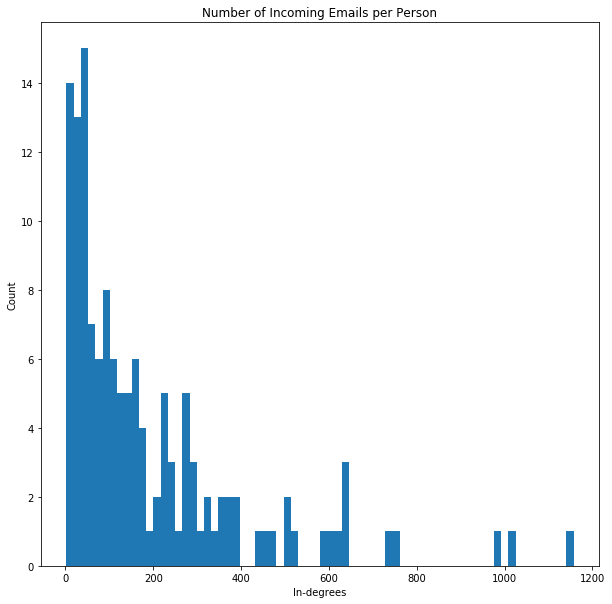

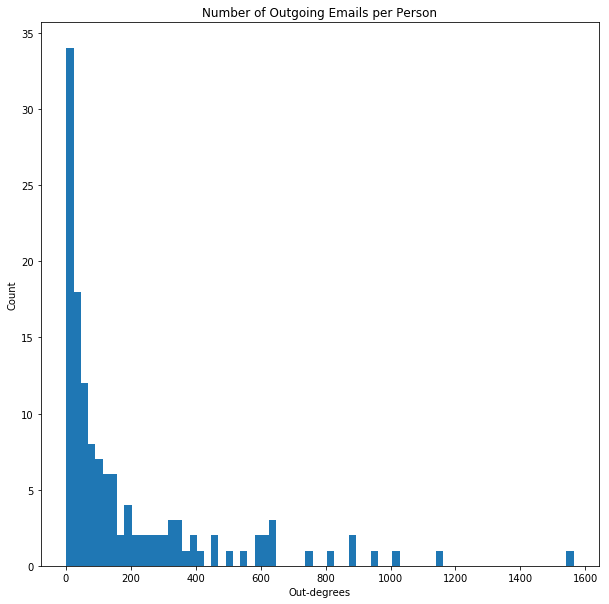

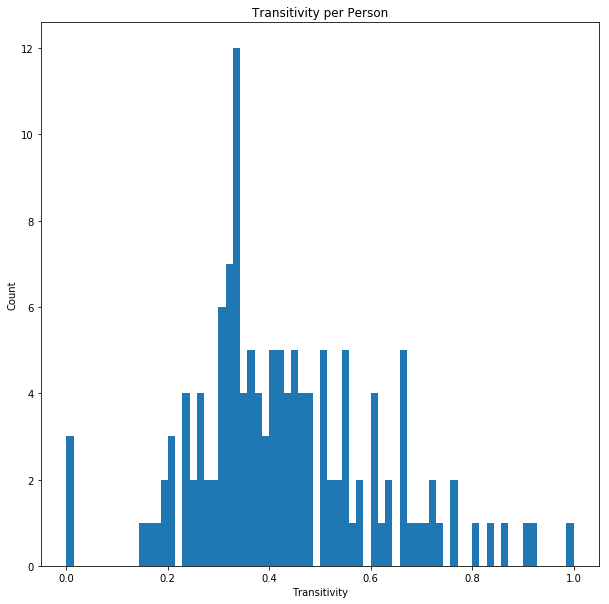

In [128]:
plt.rcParams["figure.figsize"]=10, 10

plt.hist(in_degree_collector, density = False, bins = 70)
plt.ylabel('Count')
plt.xlabel('In-degrees')
plt.title('Number of Incoming Emails per Person')
plt.show()

plt.hist(out_degree_collector, density = False, bins = 70)
plt.ylabel('Count')
plt.xlabel('Out-degrees')
plt.title('Number of Outgoing Emails per Person')
plt.show()

plt.hist(clustering_coeff_collector, density = False, bins = 70)
plt.ylabel('Count')
plt.xlabel('Transitivity')
plt.title('Transitivity per Person')
plt.show()

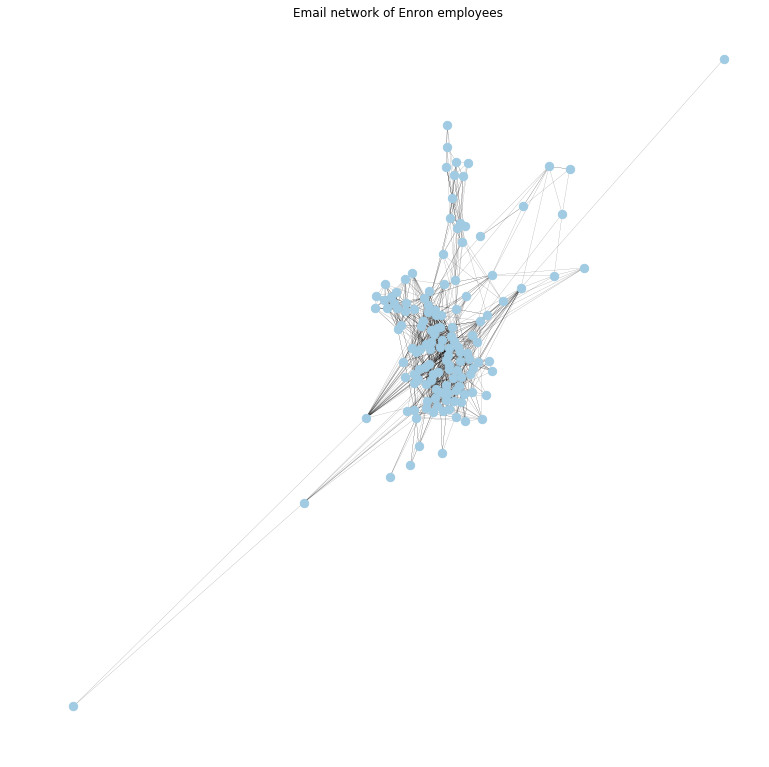

In [129]:
# Let's draw the network map
nx.draw(G, node_color='#a0CBE2', with_labels=False, arrows = False,
        node_size=70, edge_cmp=plt.cm.Blues,
        width=0.1, 
        pos=nx.fruchterman_reingold_layout(G))   # FR gives most sensible graph 
plt.title('Email network of Enron employees')
plt.rcParams["figure.figsize"]=20, 20
plt.show()  

## 5. Shortest path length 

In [130]:
length = nx.all_pairs_shortest_path_length(G_ud) # Let's use the undirected graph in order to calculate the path length
pl_list = list(length)
pl_list[6]   # This gives, for the 7th person on my node list, pairwise path-length with all the other employees in the network 

('louise.kitchen@enron.com',
 {'albert.meyers@enron.com': 4,
  'andrea.ring@enron.com': 2,
  'andrew.lewis@enron.com': 2,
  'andy.zipper@enron.com': 1,
  'barry.tycholiz@enron.com': 1,
  'benjamin.rogers@enron.com': 2,
  'bill.rapp@enron.com': 2,
  'brad.mckay@enron.com': 2,
  'cara.semperger@enron.com': 3,
  'charles.weldon@enron.com': 3,
  'chris.dorland@enron.com': 2,
  'chris.germany@enron.com': 2,
  'chris.stokley@enron.com': 3,
  'cooper.richey@enron.com': 2,
  'craig.dean@enron.com': 4,
  'dan.hyvl@enron.com': 2,
  'dana.davis@enron.com': 1,
  'danny.mccarty@enron.com': 2,
  'daren.farmer@enron.com': 2,
  'darrell.schoolcraft@enron.com': 2,
  'darron.giron@enron.com': 2,
  'david.delainey@enron.com': 1,
  'debra.perlingiere@enron.com': 2,
  'diana.scholtes@enron.com': 3,
  'don.baughman@enron.com': 3,
  'drew.fossum@enron.com': 2,
  'dutch.quigley@enron.com': 2,
  'elizabeth.sager@enron.com': 1,
  'eric.bass@enron.com': 2,
  'errol.mclaughlin@enron.com': 2,
  'fletcher.sturm@enr

In [131]:
# Let's unlist path length information
pw_path_length_list = []
for i in range(0, 135):
    for j in range(0, 135):
        node_i = pl_list[i][0]
        node_j = pl_list[i][1].keys()[j]
        paths = pl_list[i][1].values()[j]
        pw_path_length_list.append([node_i, node_j, paths])
    
pw_path_length_df = pd.DataFrame(pw_path_length_list)
pw_path_length_df.columns = ["node_i", "node_j", "s_path_length"]
print(pw_path_length_df.describe())

print ("Number of pairs with path length of zero: " + str(len(pw_path_length_df[pw_path_length_df["s_path_length"]== 0])))  
print ("Number of pairs with path length of one: " + str(len(pw_path_length_df[pw_path_length_df["s_path_length"]== 1])/2)) 
print ("Number of pairs with path length of two: " + str(len(pw_path_length_df[pw_path_length_df["s_path_length"]== 2])/2)) 
print ("Number of pairs with path length of three: " + str(len(pw_path_length_df[pw_path_length_df["s_path_length"]== 3])/2)) 
print ("Number of pairs with path length of four: " + str(len(pw_path_length_df[pw_path_length_df["s_path_length"]== 4])/2)) 
print ("Number of pairs with path length of five: " + str(len(pw_path_length_df[pw_path_length_df["s_path_length"]== 5])/2)) 
print ("Number of pairs with path length of six: " + str(len(pw_path_length_df[pw_path_length_df["s_path_length"]== 6])/2)) 
        

       s_path_length
count   18225.000000
mean        2.480219
std         0.872814
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         6.000000
Number of pairs with path length of zero: 135
Number of pairs with path length of one: 906
Number of pairs with path length of two: 3844
Number of pairs with path length of three: 3274
Number of pairs with path length of four: 922
Number of pairs with path length of five: 97
Number of pairs with path length of six: 2


Text(0.5,1,'Distribution of pairwise distance')

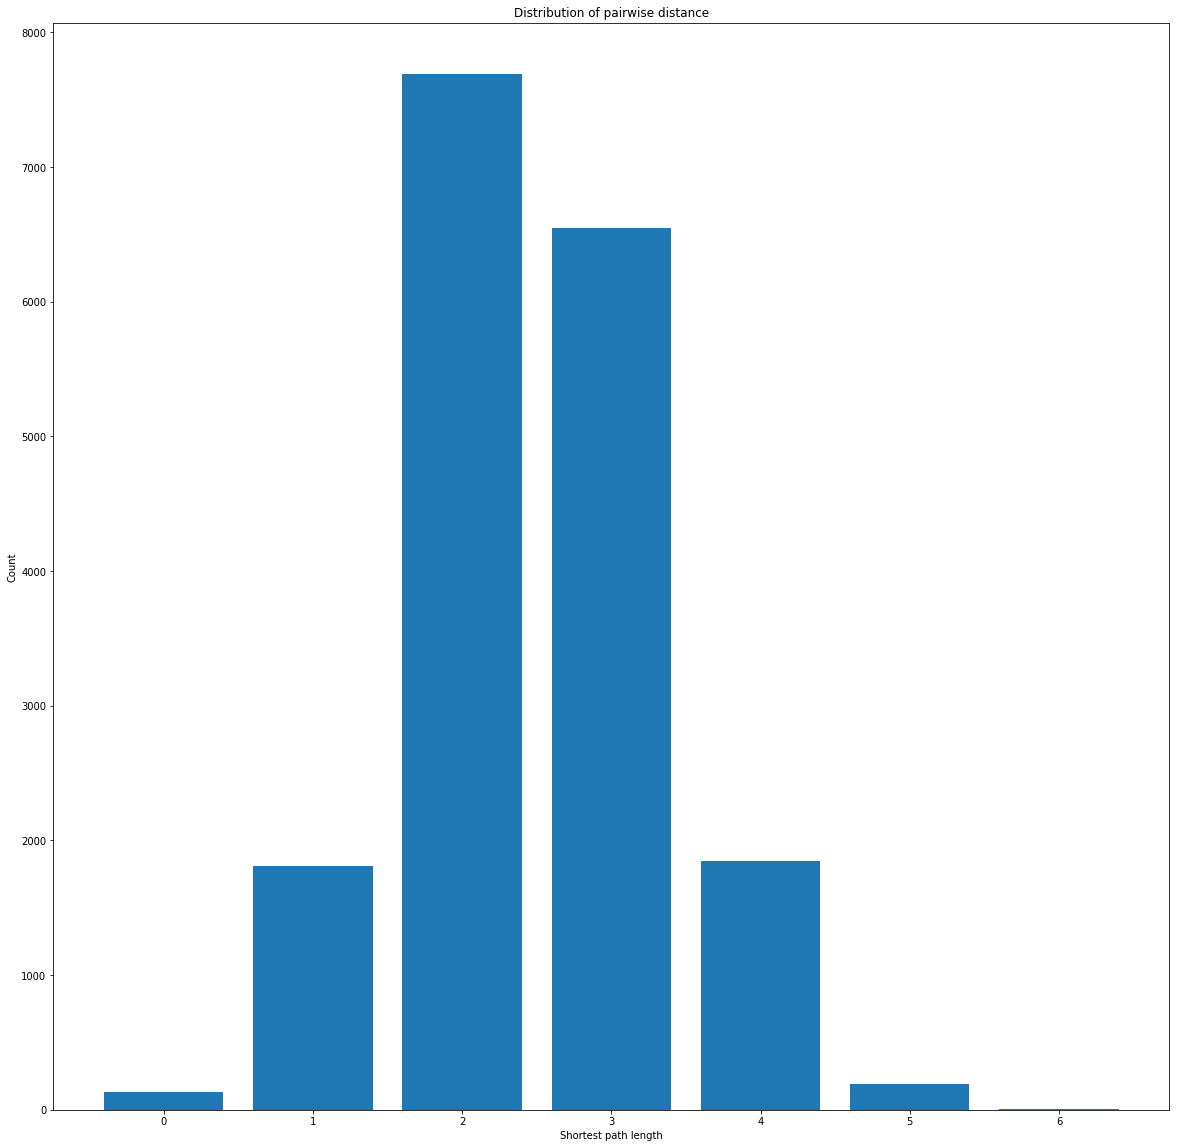

In [132]:
# Plot the distribution of path-length
the probability that random chance generated the data
his = np.histogram(pw_path_length_df["s_path_length"],bins=range(8))
fig, ax = plt.subplots()
offset = .001
plt.bar(his[1][1:],his[0])
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('0', '1', '2', '3', '4', '5', '6') )
plt.ylabel('Count')
plt.xlabel('Shortest path length')
plt.title('Distribution of pairwise distance')

## 6. Storing the pairwise path length information

In [133]:
# sort by from
pw_path_length_df = pw_path_length_df.sort_values(by='node_i', ascending=True).reset_index()
pw_path_length_df.to_csv('pw_path_length_df.csv', index=True)

## Appendix. Detecting email communities using a structural appraoch (i.e., based on modularity)

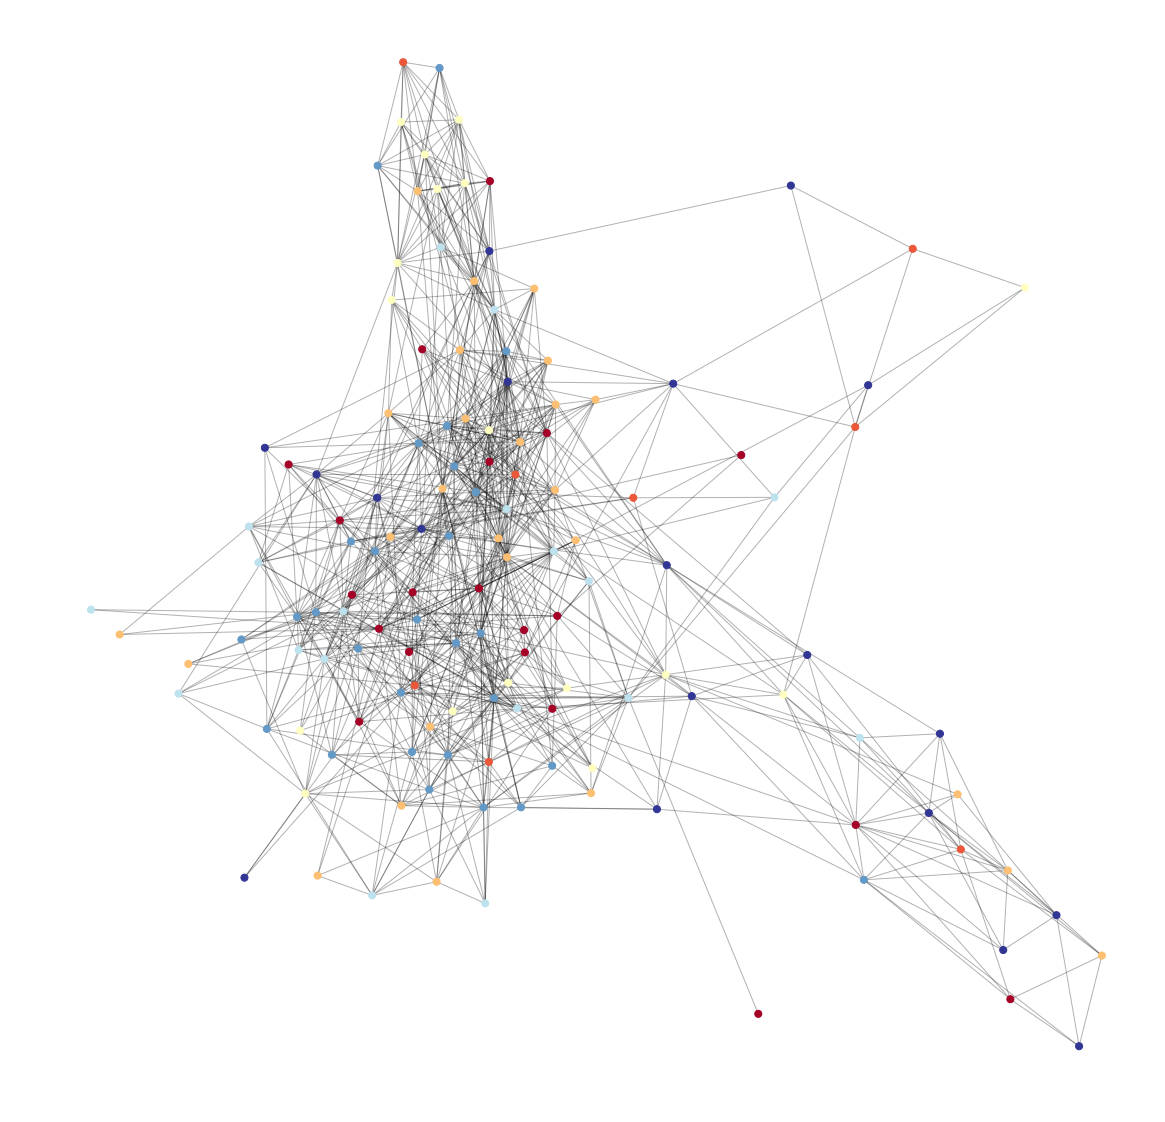

In [134]:
# Let's see how community detection algorithm(s) partition the graph (based on connectivity)
import community

partition = community.best_partition(G_ud)
pos = nx.fruchterman_reingold_layout(G_ud)
plt.figure(figsize=(20, 20))
plt.axis('off')
nx.draw_networkx_nodes(G_ud, pos, node_size=50, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G_ud, pos, alpha=0.3)
plt.show(G_ud)

#print (nx.is_weakly_connected(G))    # this graph is weekly connected
#print (nx.is_strongly_connected(G))
